In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.layers import Input, Dense, Conv1D
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [2]:
"""
### sensor_data_increased load
root_path = './data/'

dataset = pd.read_excel(''.join([root_path,'haitian-kashui.xlsx']), encoding = 'CP94')
dataset = dataset[['CurrentTemp1','CurrentTemp2','CurrentTemp3', 'CurrentTemp4','CurrentTemp5','InjEndPosi','ClpOpnTime','ClpClsTime','ChargeTime','CycleTime','TurnPosi',
                    'TurnPress','label']]

X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]
"""

C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [3]:
##################
# 데이터 load
##################
"""
 Original DataSet
 -- data.shape : (33727, 27) / 'Y': 500개
 --  data_X.shape : (20631,24)
"""

ori_train = pd.read_csv('./data/train_FD0001_true5.csv',encoding= 'cp949')
ori_test = pd.read_csv('./data/test_FD0001_true5.csv',encoding= 'cp949')
#data = pd.concat([ori_train,ori_test], axis = 0)
#data_X = data.iloc[:,:-1].values.tolist()
data = ori_train
X = data.iloc[:,2:-1].values.tolist()
y = data.iloc[:,-1]

In [4]:
###  scaling
scaled_X = preprocessing.StandardScaler().fit_transform(X)

# train, test split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

In [15]:
X_train = np.expand_dims(X_train, axis=2)
print(X_train.shape)
X_test = np.expand_dims(X_test, axis=2)
print(X_test.shape)

(16504, 24, 1)
(4127, 24, 1)


In [13]:
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(h, w, 1)) # 1ch=black&white

filter1 = 16
filter2 = 4
filter3 = 4

x = Convolution2D(filter1, kernel_size= (1, 3), activation='relu', border_mode='same')(input_img) 
x = MaxPooling2D((1, 2), border_mode='same')(x)
x = Convolution2D(filter2, 1, 2, activation='relu', border_mode='same')(x)
x = MaxPooling2D((1, 2), border_mode='same')(x)
x = Convolution2D(1, 1, 2, activation='sigmoid', border_mode='same')(x)
encoded = MaxPooling2D((1, 2), border_mode='same')(x)

x = Convolution2D(chanuel2, 1, 2, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((1, 3))(x)
x = Convolution2D(chanuel1, 1, 2, activation='relu', border_mode='same')(x)
x = UpSampling2D((1, 1))(x)
x = Convolution2D(1, 1, 2, activation='relu', border_mode='same')(x)
x = UpSampling2D((1, 2))(x)
decoded = Convolution2D(1, 1, 3, activation='sigmoid', border_mode='same')(x)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse', metrics = ['mse'])


autoencoder.fit(x_train, x_train, nb_epoch= 50, batch_size=50,             # nb_epoch 높으면 오래걸리니까 일단 2 나중에 50
               shuffle=True, validation_data=(x_test, x_test), verbose=1) 

C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (1, 3), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((1, 2), padding="same")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2, (1, 2), activation="relu", padding="same")`
  if sys.path[0] == '':
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((1, 2), padding="same")`
  del sys.path[0]
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py

ValueError: Error when checking target: expected conv2d_7 to have shape (1, 18, 1) but got array with shape (1, 24, 1)

In [37]:
encoder = Model(input_img, encoded)
encoder.compile(optimizer='adadelta', loss='mse')
# encoder.save('./result/encoder.h5')

enco_train_pred = encoder.predict(x_train)
enco_test_pred = encoder.predict(x_test)

enco_train_re = np.reshape(enco_train_pred,(len(enco_train_pred),2))
enco_test_re = np.reshape(enco_test_pred,(len(enco_test_pred),2))
enco_merge = np.concatenate((enco_train_re,enco_test_re), axis = 0)

X_reduce = pd.DataFrame()
X_reduce['x'] = [enco_merge[x][0] for x in range(0,len(enco_merge))]
X_reduce['y'] = [enco_merge[x][1] for x in range(0,len(enco_merge))]

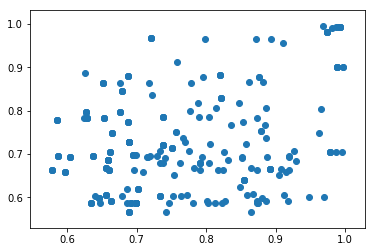

In [38]:
plt.scatter(X_reduce['x'], X_reduce['y'])

In [39]:
cnn_predict = autoencoder.predict(x_scaled)

In [40]:
cnn_predict = cnn_predict.reshape(cnn_predict.shape[0],cnn_predict.shape[2])
print(cnn_predict.shape)

(300, 12)


In [41]:
scaled_X.shape

(300, 12)

In [42]:
### calculate MSE
mse = mean_squared_error(scaled_X.T, cnn_predict.T, multioutput='raw_values')
mse.shape

(300,)

In [43]:
np.max(mse), np.min(mse) , np.mean(mse)

(5.403606562894333, 0.09350234194884548, 1.0519300555211597)

In [58]:
### labeling
# mse < border
border = 4.5
label= [0 if  mse[x] < border else 1 for x in range(0,len(mse)) ]
X_reduce['label'] = label
idx_0 = X_reduce[X_reduce.label == 0].index
idx_1 = X_reduce[X_reduce.label == 1].index
print(len(idx_0))
print(len(idx_1))

285
15


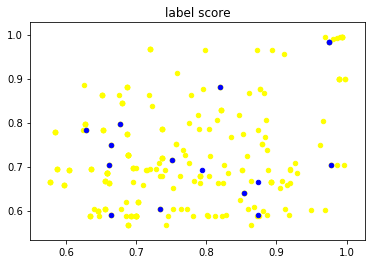

In [59]:
plt.title("label score")
# plt.xlim(-0.65, -0.3)
# plt.ylim(-3.5, -0.5)


b1 = plt.scatter(X_reduce['x'][X_reduce.label == 0], X_reduce['y'][X_reduce.label == 0], c='yellow',s=20)
b1 = plt.scatter(X_reduce['x'][X_reduce.label == 1], X_reduce['y'][X_reduce.label == 1], c='blue',s=20)

plt.show()

In [60]:
### 정상 데이터(복원률 높은것)만 가지고 다시 training
X_train2 = scaled_X[idx_0]
X_train2 = np.reshape(X_train2,(len(X_train2),h,w,1))
autoencoder.fit(X_train2, X_train2, epochs=50, batch_size=20, shuffle=True)

Epoch 1/50
285/285 [==============================] - 0s 316us/step - loss: 0.8087 - mean_squared_error: 0.8087
Epoch 2/50
285/285 [==============================] - 0s 323us/step - loss: 0.8087 - mean_squared_error: 0.8087
Epoch 3/50
285/285 [==============================] - 0s 351us/step - loss: 0.8086 - mean_squared_error: 0.8086
Epoch 4/50
285/285 [==============================] - 0s 326us/step - loss: 0.8085 - mean_squared_error: 0.8085
Epoch 5/50
285/285 [==============================] - 0s 305us/step - loss: 0.8084 - mean_squared_error: 0.8084
Epoch 6/50
285/285 [==============================] - 0s 316us/step - loss: 0.8084 - mean_squared_error: 0.8084
Epoch 7/50
285/285 [==============================] - 0s 309us/step - loss: 0.8083 - mean_squared_error: 0.8083
Epoch 8/50
285/285 [==============================] - 0s 326us/step - loss: 0.8082 - mean_squared_error: 0.8082
Epoch 9/50
285/285 [==============================] - 0s 316us/step - loss: 0.8082 - mean_squared_error:

In [61]:
# 전체 데이터셋을 대상으로 인코더로 특성 추출
a = encoder.predict(x_scaled)
a = a.reshape(a.shape[0], a.shape[2])
pre_enco_X2 = pd.DataFrame(a)

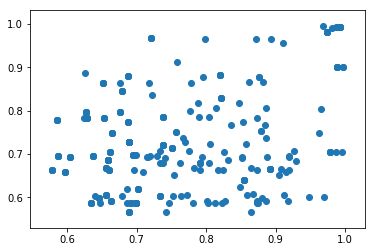

In [62]:
plt.scatter(pre_enco_X2[0], pre_enco_X2[1])

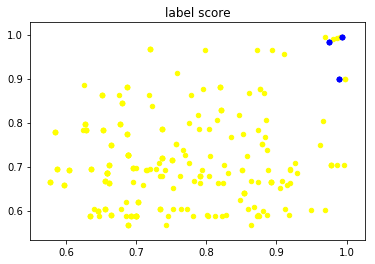

In [63]:
plt.title("label score")
# plt.xlim(-0.65, -0.3)
# plt.ylim(-3.5, -0.5)

b1 = plt.scatter(pre_enco_X2.iloc[idx_0,0], pre_enco_X2.iloc[idx_0,1], c='yellow',s=20)
b1 = plt.scatter(pre_enco_X2.iloc[idx_1,0], pre_enco_X2.iloc[idx_1,1], c='blue',s=20)

plt.show()